# Train DenseNet121 from skratch on chest dataset

In [153]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [154]:
import os, sys
import torch, torchvision
from torch import nn, cuda

In [155]:
NB_DIR = %pwd

In [156]:
sys.path.append(f'{NB_DIR}/../fastai')

Will use some fastai functinality:

In [157]:
import fastai

## Pytorch model
(We'll build our model on Pytorch's `densenet121`)

In [158]:
from torchvision.models import densenet121, densenet161

In [159]:
?densenet121()

Signature: densenet121(pretrained=False, **kwargs)
Docstring:
Densenet-121 model from
`"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

Args:
    pretrained (bool): If True, returns a model pre-trained on ImageNet
File:      ~/anaconda3/envs/fastai/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/models/densenet.py
Type:      function


**Load dn121**

Later we'll modify the final few layers

In [160]:
m = densenet121()

In [161]:
#m

### Fast ai data loader

In [162]:
DATA_DIR = f'/data1/NIH-chest-xrays/'

In [163]:
XRAY_PATH = DATA_DIR
XRAY_IMGS = f"{XRAY_PATH}/images/"

In [164]:
diagnosis = 'pneumothorax'

In [165]:
labels = f'train_labels_{diagnosis}_balanced_testAsVal.csv'

In [166]:
bs=16

In [167]:
def get_data(sz):
    tfms = fastai.transforms.tfms_from_model(model, sz, aug_tfms=fastai.transforms.RandomFlip(), 
                                             max_zoom=None)
    return fastai.dataset.ImageClassifierData.from_csv(XRAY_PATH, 'images', 
                                        labels, bs=bs, tfms=tfms)

In [168]:
sz=299
data = get_data(sz)

## Create custom model:

**Cut the final layer from Pytorch's densenet (it has 1000 outputs)**

In [169]:
def cut_model(m, cut):
    return list(m.children())[:cut]

In [170]:
cut=1

In [171]:
layers = cut_model(m, cut)

In [172]:
layers

[Sequential(
   (conv0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   (relu0): ReLU(inplace)
   (pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
   (denseblock1): _DenseBlock(
     (denselayer1): _DenseLayer(
       (norm.1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
       (relu.1): ReLU(inplace)
       (conv.1): Conv2d (64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (norm.2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
       (relu.2): ReLU(inplace)
       (conv.2): Conv2d (128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     )
     (denselayer2): _DenseLayer(
       (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
       (relu.1): ReLU(inplace)
       (conv.1): Conv2d (96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (norm.2): BatchNorm2d(128, eps=1e-05, 

**Add some custom fastai layers:**

In [173]:
layers += [fastai.layers.AdaptiveConcatPool2d(), fastai.layers.Flatten()]

In [174]:
#layers

Additional layers to be added (these are automatically added when using `ConvLearner.pretrained`):

In [175]:
#  (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True)
#  (4): Dropout(p=0.7)
#  (5): Linear(in_features=2048, out_features=512)
#  (6): ReLU()
#  (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
#  (8): Dropout(p=0.7)
#  (9): Linear(in_features=512, out_features=2)
#  (10): LogSoftmax()

In [176]:
# No dropout
p = 0.0

In [177]:
fc_layers = [nn.BatchNorm1d(2048), 
             nn.Dropout(p),
             nn.Linear(2048, 512),
             nn.ReLU(),
             nn.BatchNorm1d(512),
             nn.Dropout(p),
             nn.Linear(512, 2),
             nn.LogSoftmax()
            ]

In [178]:
all_layers = layers + fc_layers

In [141]:
#all_layers

**Make a Pytorch model having these layers**:

In [179]:
m = nn.Sequential(*all_layers)

Check:

In [180]:
m

Sequential(
  (0): Sequential(
    (conv0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm.1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm.2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU(inplace)
        (conv.2): Conv2d (128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (n

Now we can use fastai's `ConvLearner`. To take advantage of fastai functionality.

In [181]:
learn = fastai.conv_learner.ConvLearner.from_model_data(m, data)

## Fit the model

In [136]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████  | 4820/5935 [12:44<02:56,  6.30it/s, loss=2.52]

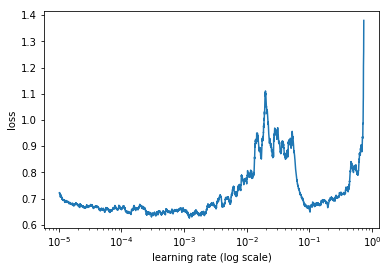

In [146]:
learn.sched.plot()

In [182]:
lr=(10e-3+10e-4)/2

In [ ]:
learn.fit(lr,2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

  7%|▋         | 428/5935 [01:27<18:49,  4.87it/s, loss=0.717]